In [1]:
import pandas as pd
import os

In [2]:

os.chdir(path)

data = pd.read_excel('主订单数据集.xlsx')
data = data.dropna()


#use quantile to remove outline value
df = data.copy()
top = df['实付金额'].quantile(0.75) + (df['实付金额'].quantile(0.75)-df['实付金额'].quantile(0.25))*3
bottom = df['实付金额'].quantile(0.25) - (df['实付金额'].quantile(0.75)-df['实付金额'].quantile(0.25))*3
df = df.loc[df['实付金额'] <= top,:]


# process buy number
#so we can keep BuyNum <=7, which take 99.974%
df = df.loc[df['购买数量'] <= 7, :]


#process 订单状态
df['订单状态'].value_counts()
#only keep sucess
df = df.loc[df['订单状态'] == '交易成功', :]
df.head()

,品牌名,店铺名称,主订单编号,用户ID,付款时间,订单状态,实付金额,购买数量
0,阿粥（小z）,数据不吹牛,73465136654,uid135460366,2023-01-01 09:32:12,交易成功,166,1
1,阿粥（小z）,数据不吹牛,73465136655,uid135460367,2023-01-01 09:11:50,交易成功,117,1
2,阿粥（小z）,数据不吹牛,73465136656,uid135460368,2023-01-01 11:49:02,交易成功,166,1
3,阿粥（小z）,数据不吹牛,73465136657,uid135460369,2023-01-01 12:20:24,交易成功,77,1
4,阿粥（小z）,数据不吹牛,73465136658,uid135460370,2023-01-01 01:23:15,交易成功,158,1


In [10]:
group = df.groupby('用户ID')['实付金额'].sum().sort_values(ascending=True).reset_index()
group.head()

,用户ID,实付金额
0,uid135602056,40
1,uid135493227,40
2,uid135477839,40
3,uid135484598,40
4,uid135533002,40


<AxesSubplot:>

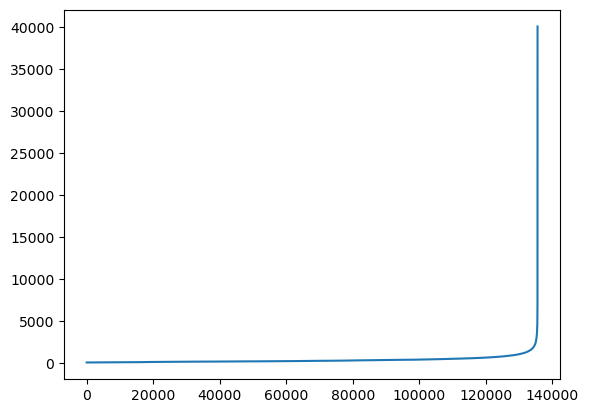

In [11]:
group['实付金额'].plot()

In [17]:
# set bins
bins = list(range(0, 1600,100)) + [100000]
ranges = [str(x-100)+'~'+str(x) for x in range(100, 1600,100)]
ranges.append('1500+')
group['Bins'] = pd.cut(group['实付金额'], bins=bins, labels=ranges)
group

,用户ID,实付金额,Bins
0,uid135602056,40,0~100
1,uid135493227,40,0~100
2,uid135477839,40,0~100
3,uid135484598,40,0~100
4,uid135533002,40,0~100
...,...,...,...
135522,uid135465649,21015,1500+
135523,uid135473980,24158,1500+
135524,uid135467627,30916,1500+
135525,uid135460679,35543,1500+


In [18]:
#add user who buy again
repur = pd.read_excel('2024年1-3月复购用户.xlsx')
group['Repur'] = group['用户ID'].isin(repur['用户ID'])
group

,用户ID,实付金额,Bins,Repur
0,uid135602056,40,0~100,False
1,uid135493227,40,0~100,False
2,uid135477839,40,0~100,True
3,uid135484598,40,0~100,True
4,uid135533002,40,0~100,False
...,...,...,...,...
135522,uid135465649,21015,1500+,False
135523,uid135473980,24158,1500+,False
135524,uid135467627,30916,1500+,False
135525,uid135460679,35543,1500+,True


In [22]:
df_final = group.groupby('Bins').agg({'用户ID':'count', 'Repur':'sum'})
df_final

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5320\2364707530.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final = group.groupby('Bins').agg({'用户ID':'count', 'Repur':'sum'})


,用户ID,Repur
Bins,,
0~100,21036,1533
100~200,40010,5163
200~300,23078,3898
300~400,17997,3547
400~500,10045,2018
500~600,6636,1345
600~700,4290,879
700~800,2945,617
800~900,2061,491


In [24]:
df_final.columns = ['Users', 'Repur']
df_final['RepurRate'] = df_final['Repur']/df_final['Users']
df_final = df_final.reset_index()
df_final

,Users,Repur,RepurRate
Bins,,,
0~100,21036,1533,0.072875
100~200,40010,5163,0.129043
200~300,23078,3898,0.168905
300~400,17997,3547,0.197088
400~500,10045,2018,0.200896
500~600,6636,1345,0.202682
600~700,4290,879,0.204895
700~800,2945,617,0.209508
800~900,2061,491,0.238234


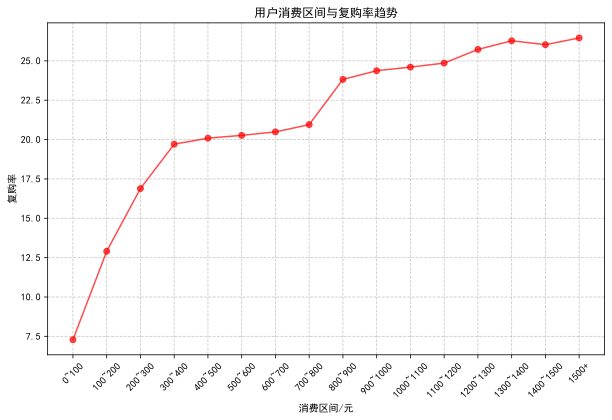

In [31]:
#visualize
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

fig = plt.figure(figsize=(10,6))

plt.plot(df_final['Bins'], df_final['RepurRate']*100, marker='o', color='r', alpha=0.7 )

plt.title('用户消费区间与复购率趋势')
plt.xlabel('消费区间/元')
plt.ylabel('复购率')

plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)